In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.model_selection import KFold

In [100]:
df = pd.read_csv('data-week-3.csv')

columns=['Make','Model','Year','Engine HP','Engine Cylinders','Transmission Type','Vehicle Style','highway MPG','city mpg','MSRP']
df_filt=df[columns]

df_filt.columns = df_filt.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df_filt.dtypes[df_filt.dtypes == 'object'].index)
numerical_columns=list(df_filt.dtypes[df_filt.dtypes != 'object'].index)

for c in categorical_columns:
    df_filt[c] = df_filt[c].str.lower().str.replace(' ', '_')
for c in numerical_columns:
    df_filt[c] = df_filt[c].fillna(0)

/tmp/ipykernel_2351/2651704231.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt[c] = df_filt[c].str.lower().str.replace(' ', '_')
/tmp/ipykernel_2351/2651704231.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt[c] = df_filt[c].fillna(0)


In [101]:
df_filt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_hp          11914 non-null  float64
 4   engine_cylinders   11914 non-null  float64
 5   transmission_type  11914 non-null  object 
 6   vehicle_style      11914 non-null  object 
 7   highway_mpg        11914 non-null  int64  
 8   city_mpg           11914 non-null  int64  
 9   msrp               11914 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 930.9+ KB


In [102]:
df_filt['above_average']=(df_filt.msrp > df_filt.msrp.mean()).astype(int)
del df_filt['msrp']
numerical_columns.remove('msrp')

/tmp/ipykernel_2351/2017108242.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['above_average']=(df_filt.msrp > df_filt.msrp.mean()).astype(int)


In [103]:
df_full_train, df_test = train_test_split(df_filt, test_size=0.2, random_state=1) 
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [104]:
for c in numerical_columns:
    print(c, roc_auc_score(df_train.above_average, df_train[c]))

year 0.687551492804683
engine_hp 0.9171031265539011
engine_cylinders 0.766116490165669
highway_mpg 0.3669412128227987
city_mpg 0.3265755356754767


In [105]:
dv = DictVectorizer(sparse=True)
y_train=df_train.above_average
y_val=df_val.above_average
train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)
model=LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_predicts = model.predict_proba(X_val)[:, 1].round(3)
# y_pred = (y_predicts >= 0.5)
y_pred =model.predict(X_val)
round(roc_auc_score(y_val, y_pred),3)

0.919

In [106]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_predicts >= t)
    predict_negative = (y_predicts < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1=2*(p*r)/(p+r)
    scores.append((t, tp, fp, fn, tn,p,r,f1))
columns = ['threshold', 'tp', 'fp', 'fn', 'tn','p','r','f1']
df_scores = pd.DataFrame(scores, columns=columns)

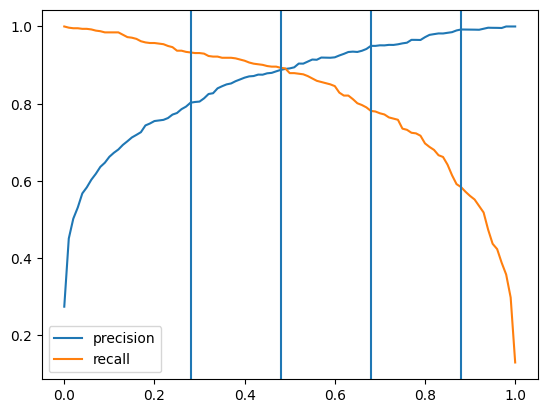

In [107]:
plt.plot(df_scores.threshold, df_scores['p'], label='precision')
plt.plot(df_scores.threshold, df_scores['r'], label='recall')
xcoords = [0.28, 0.48, 0.68,0.88]
for xc in xcoords:
    plt.axvline(x=xc)
plt.legend()

In [108]:
df_scores[df_scores.threshold.round(2)==.48]

,threshold,tp,fp,fn,tn,p,r,f1
48,0.48,584,74,70,1655,0.887538,0.892966,0.890244


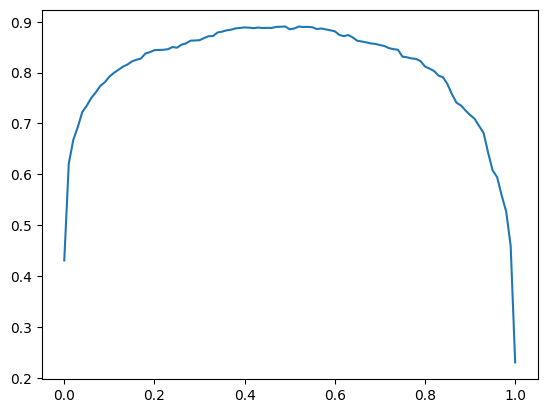

In [109]:
plt.plot(df_scores.threshold, df_scores['f1'], label='f1')


In [110]:
df_scores[df_scores.f1==df_scores.f1.max()]

,threshold,tp,fp,fn,tn,p,r,f1
49,0.49,583,72,71,1657,0.890076,0.891437,0.890756


In [111]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=True)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [112]:
def predict(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [113]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train, C=1)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(' %.3f +- %.3f' % ( np.mean(scores), np.std(scores)))

 0.979 +- 0.001


In [114]:
n_splits = 5


for C in [0.01, 0.1, 0.5, 10]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.above_average.values
        y_val = df_val.above_average.values
    
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print('C=%s %.3f +- %.3f' % ( C, np.mean(scores), np.std(scores)))

C=0.01 0.952 +- 0.002
C=0.1 0.972 +- 0.002
C=0.5 0.980 +- 0.002
C=10 0.983 +- 0.003
